In [1]:
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss, RMSE, MAPE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting.data import NaNLabelEncoder

from sklearn.preprocessing import MinMaxScaler
import random
import os

In [2]:
def set_seed(seed):
    # seed init.
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

    # torch seed init.
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False # train speed is slower after enabling this opts.

    # https://pytorch.org/docs/stable/generated/torch.use_deterministic_algorithms.html
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

    # avoiding nondeterministic algorithms (see https://pytorch.org/docs/stable/notes/randomness.html)
    torch.use_deterministic_algorithms(True, warn_only=True)

set_seed(42)

In [3]:
data = pd.read_csv('yield_whole_variables.csv')
data.head(50)

,series,time_idx,carbon_Yield,open_Yield,high_Yield,low_Yield,volume_Yield,stoxx_Yield,gas_Yield,oil_Yield,coal_Yield,baseload_Yield,pos_Yield,neg_Yield,trends_Yield,pos_s_Yield,neg_s_Yield,trends_s_Yield
0,0,0,-2.207727,1.646005,-1.816101,-0.544631,2.371653,-0.350438,-9.578127,4.796028,-6.559728,-7.097672,0.000000,0.000000,0.000000,-28.889047,64.784733,0.940620
1,0,1,2.030527,0.059347,0.147689,0.181873,-109.083015,1.813940,-2.000628,1.297516,-1.006590,1.168426,0.000000,0.000000,0.000000,24.507436,-48.320559,-34.122427
2,0,2,3.314257,1.003550,3.252319,3.071659,100.097382,0.295058,9.247330,0.147221,3.592285,5.740317,0.000000,0.000000,0.000000,34.494267,112.615377,69.862084
3,0,3,0.484953,3.350010,0.995033,1.457752,31.299988,0.294190,4.395757,2.917666,2.812917,4.709577,0.000000,0.000000,0.000000,-170.273489,-175.656571,-72.275592
4,0,4,-1.087278,0.226950,0.141343,-0.260832,-37.469345,-0.466201,8.841096,-0.591135,0.000000,2.053460,-36.315873,-13.809136,-2.469261,183.395044,117.555888,27.023126
5,0,5,0.344630,-1.974596,0.535288,-0.058055,17.471696,0.024591,15.518441,1.639381,2.877896,4.577260,0.000000,0.000000,0.000000,-75.678036,-1.363646,21.937619
6,0,6,-2.908873,0.375018,-2.101156,-3.276079,41.810750,0.171969,-17.252852,-0.923302,-0.497690,-7.064639,0.000000,0.000000,0.000000,79.752286,-21.134208,-8.816948
7,0,7,-0.354820,-2.803103,-2.557536,-1.025341,-20.570849,0.660553,-3.133293,0.640116,-0.357016,-2.198293,0.000000,0.000000,0.000000,-57.397770,16.893872,-22.827020
8,0,8,-5.479155,-0.415431,-1.005926,-3.391200,7.718964,-1.029421,-6.206073,-2.367399,-1.877311,-4.353451,0.000000,0.000000,0.000000,10.599668,35.283276,22.930223
9,0,9,-0.376176,-5.500928,-3.387079,-1.040199,-36.899543,0.270636,-7.866764,-0.637235,-1.987552,0.000000,38.255085,-17.539859,0.000000,-24.666788,-28.641762,-21.627071


In [4]:
data = data.astype(dict(series=str))

In [5]:
#Train, Validation, Test Split
n = len(data)
training_df = data[0:int(n * 0.8)]
validation_df = data[int(n * 0.8):int(n * 0.9)]
test_df = data[int(n * 0.9):]

In [6]:
max_prediction_length = 1
max_encoder_length = 5
#training_cutoff = training_df["time_idx"].max() - max_prediction_length*2

training = TimeSeriesDataSet(
    training_df,
    #training_df[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="carbon_Yield",
    group_ids=["series"],
    min_encoder_length=max_encoder_length,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,

    max_prediction_length=max_prediction_length,
    categorical_encoders={"series": NaNLabelEncoder().fit(training_df.series)},
    static_categoricals=["series"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "carbon_Yield",
        "open_Yield",
        "high_Yield",
        "low_Yield",
        "volume_Yield",
        "stoxx_Yield",
        "gas_Yield",
        "oil_Yield",
        "coal_Yield",
        "baseload_Yield",
        # "pos_Yield",
        # "neg_Yield",
        # "trends_Yield",
        "pos_s_Yield",
        "neg_s_Yield",
        "trends_s_Yield"
    ],
    add_relative_time_idx=True,
)


In [7]:
validation = TimeSeriesDataSet.from_dataset(training, validation_df, predict=False, stop_randomization=True)
test = TimeSeriesDataSet.from_dataset(training, test_df, predict=False, stop_randomization=True)

# create dataloaders for model
batch_size = 64  # set this between 32 to 128

train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
test_dataloader = test.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [8]:
# and load the first batch
x, y = next(iter(train_dataloader))
print("x =", x)
print("\ny =", y)
print("\nsizes of x =")
for key, value in x.items():
    print(f"\t{key} = {value.size()}")                              

x = {'encoder_cat': tensor([[[0],
         [0],
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
         [0],
         [0]],

        [[0],
         [0],
         [0],
  

In [570]:
import pickle
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    train_dataloader,
    model_path="optuna_test",
    n_trials=50,
    max_epochs=300,
    gradient_clip_val_range=(0.1, 0.1),
    hidden_size_range=(4, 256),
    hidden_continuous_size_range=(2, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.0001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=64, accelerator="cpu"),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)
# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)
    
# show best hyperparameters
print(study.best_trial.params)

[I 2024-04-12 19:55:23,482] A new study created in memory with name: no-name-8c7c0647-a4d2-41a6-a9cd-3e717449de27
/root/miniconda3/lib/python3.10/site-packages/pytorch_forecasting/models/temporal_fusion_transformer/tuning.py:124: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gradient_clip_val = trial.suggest_loguniform("gradient_clip_val", *gradient_clip_val_range)
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/root/miniconda3/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
/root/miniconda3/lib/python3.10/site-packages/pytorch_forecasting/models/temporal_fusi

In [ ]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="train_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

pl.seed_everything(42)
trainer = pl.Trainer(
    max_epochs=1000,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=study.best_trial.params['learning_rate'],
    hidden_size=study.best_trial.params['hidden_size'],
    attention_head_size=study.best_trial.params['attention_head_size'],
    dropout=study.best_trial.params['dropout'],
    hidden_continuous_size=study.best_trial.params['hidden_continuous_size'],
    loss=QuantileLoss(),
    # log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")


In [157]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="train_loss", min_delta=1e-5, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

pl.seed_everything(42, workers=True)
#pl.Trainer(deterministic=True)
trainer = pl.Trainer(
    max_epochs=300,
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=64,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,

)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.2,
    hidden_size=115,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=44,
    loss=QuantileLoss(),
    # log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,

)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")


Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 936.9k


/root/miniconda3/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/root/miniconda3/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [158]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1     
3  | prescalers                         | ModuleDict                      | 1.3 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 345   
5  | encoder_variable_selection         | VariableSelectionNetwork        | 237 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 30.4 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 53.6 K
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 53.6 K
9  | static_context_initial_cell_lstm 

Sanity Checking: 0it [00:00, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 52 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/root/miniconda3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 52 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/root/miniconda3/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50)

Training: 0it [00:00, ?it/s]

/root/miniconda3/lib/python3.10/site-packages/torch/autograd/__init__.py:200: UserWarning: upsample_linear1d_backward_out_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:71.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [159]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [160]:
predictions = best_tft.predict(test_dataloader, mode="prediction", return_x=True)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/miniconda3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 52 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


In [ ]:
predictions.x['decoder_target']

In [ ]:
predictions.output

In [163]:
predictions.output.shape

torch.Size([76, 1])

In [164]:
predict = np.array(predictions.output.cpu())

In [165]:
d=np.concatenate(predict, axis=0)
d.shape

(76,)

76
76


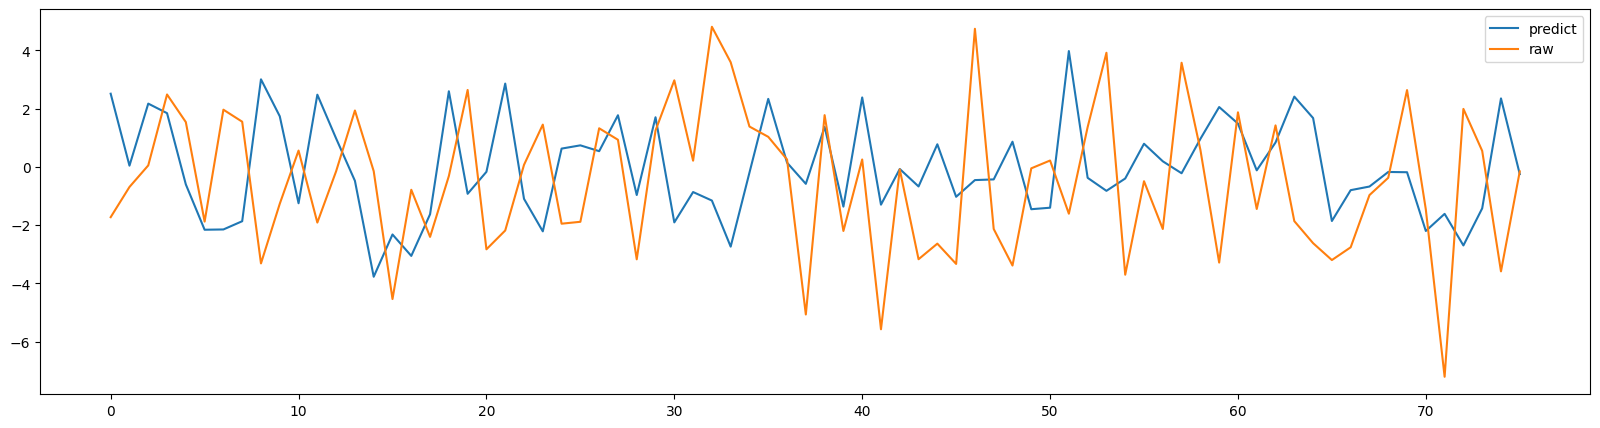

In [166]:
import matplotlib.pyplot as plt
predict = np.array(predictions.output.cpu())
raw = np.array(predictions.x['decoder_target'].cpu())
predict=np.concatenate(predict, axis=0)
raw=np.concatenate(raw, axis=0)

plt.figure(figsize=(20, 5))
plt.plot(predict, label="predict")
plt.plot(raw, label="raw")
plt.legend();

print(len(predict))
print(len(raw))

In [167]:
predict = pd.DataFrame(predict, columns=['predict'])
raw = pd.DataFrame(raw, columns=['raw'])
df = pd.concat([predict, raw], axis=1)
df
# df.to_csv('TFT_test_compare.csv')

,predict,raw
0,2.515133,-1.724631
1,0.044566,-0.687651
2,2.175075,0.053064
3,1.847180,2.488668
4,-0.598931,1.540467
...,...,...
71,-1.610856,-7.204929
72,-2.695251,1.993545
73,-1.421466,0.551878
74,2.353978,-3.585818


In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

rmse = sqrt(mean_squared_error(df['raw'], df['predict']))
print('Test RMSE: %.4f' % rmse)
mae = mean_absolute_error(df['raw'], df['predict'])
print('Test MAE: %.4f' % mae)
mape = mean_absolute_percentage_error(df['raw'], df['predict'])
print('Test MAPE: %.4f' % mape)

def Dstat(y_true, y_pred):
    n = len(y_true)
    Dstat = sum(np.array(y_true * y_pred > 0).astype(int))/n
    return Dstat
print('Test Dstat: %.4f' % Dstat(df['raw'], df['predict']))

In [144]:
df.to_csv('TFT_predict.csv',index=None)

In [ ]:
attentions.output

In [ ]:
interpretation

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/miniconda3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 52 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


tensor([ 1.3475,  2.7877,  1.2182,  1.8883, 34.9080,  0.9229,  3.1175,  2.0356,
         7.7415,  2.2016,  3.0339,  4.8793,  6.6876,  1.7004,  1.5299],
       device='cuda:0')


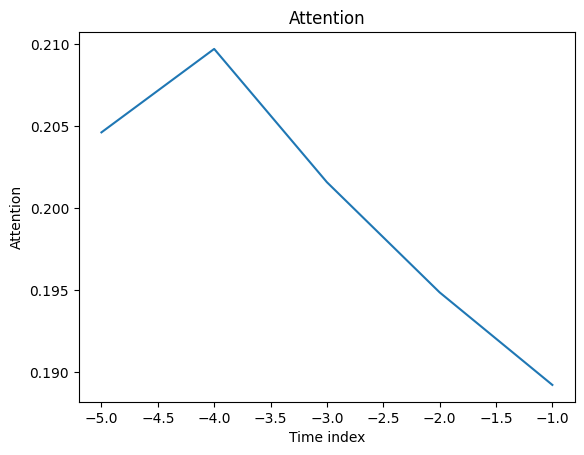

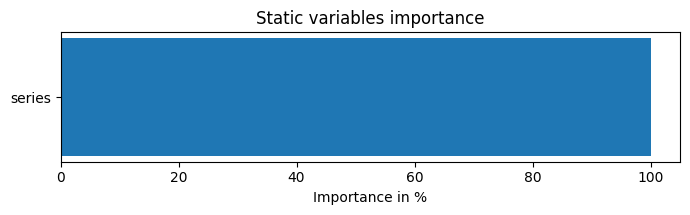

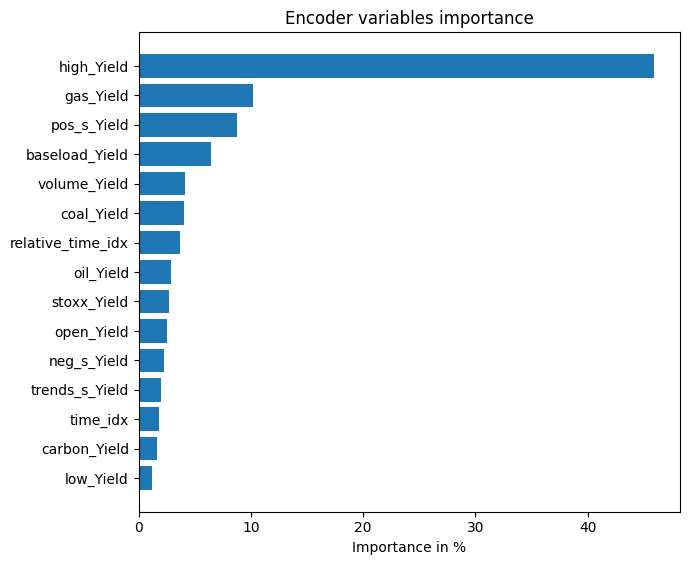

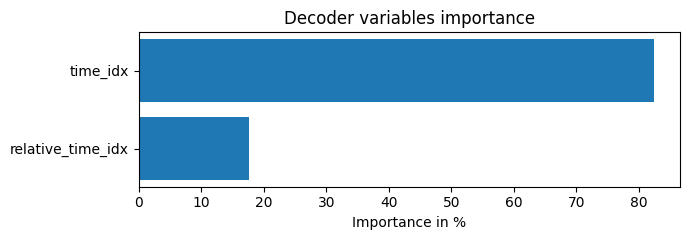

In [251]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
attentions = best_tft.predict(test_dataloader, mode="raw", return_x=True)

interpretation = best_tft.interpret_output(attentions.output, reduction="sum")
best_tft.plot_interpretation(interpretation)

print(interpretation['encoder_variables'])

In [ ]:
heatmap['time_idx'].sum()

In [248]:
heatmap = pd.DataFrame(np.array(interpretation['encoder_variables'].cpu()), 
                       columns=['relative_time_idx','time_idx',
                           "carbon_Yield",
        "open_Yield",
        "high_Yield",
        "low_Yield",
        "volume_Yield",
        "stoxx_Yield",
        "gas_Yield",
        "oil_Yield",
        "coal_Yield",
        "baseload_Yield",
        # "pos_Yield",
        # "neg_Yield",
        # "trends_Yield",
        "pos_s_Yield",
        "neg_s_Yield",
        "trends_s_Yield"])
heatmap.to_csv('interpretation_variables_heatmap.csv',index=0)
heatmap

,relative_time_idx,time_idx,carbon_Yield,open_Yield,high_Yield,low_Yield,volume_Yield,stoxx_Yield,gas_Yield,oil_Yield,coal_Yield,baseload_Yield,pos_s_Yield,neg_s_Yield,trends_s_Yield
0,0.011465,0.020031,0.010083,0.016715,0.699883,0.010069,0.033169,0.018483,0.057101,0.009090,0.026685,0.027804,0.033794,0.013330,0.012297
1,0.012227,0.019457,0.013014,0.019618,0.663347,0.008207,0.035244,0.022055,0.068294,0.008806,0.030233,0.026675,0.037892,0.018585,0.016344
2,0.012661,0.019263,0.012771,0.019056,0.672428,0.009495,0.033450,0.021614,0.066114,0.008390,0.029153,0.024152,0.038810,0.017128,0.015515
3,0.012581,0.017356,0.013464,0.019544,0.668060,0.009559,0.034033,0.022432,0.067848,0.008764,0.030097,0.021931,0.040146,0.017941,0.016245
4,0.013892,0.017184,0.009837,0.017190,0.685802,0.017214,0.027675,0.018035,0.030258,0.044209,0.028634,0.040880,0.022549,0.014949,0.011692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.018058,0.035654,0.017662,0.026770,0.383501,0.014651,0.057947,0.028813,0.133879,0.020452,0.043424,0.068774,0.104454,0.023394,0.022568
72,0.020008,0.037225,0.019961,0.029053,0.307319,0.013128,0.060453,0.031259,0.167163,0.017227,0.044647,0.059864,0.142570,0.025832,0.024291
73,0.016252,0.030683,0.017743,0.025883,0.415286,0.011502,0.051326,0.028385,0.133889,0.014889,0.040779,0.053000,0.113262,0.023622,0.023500
74,0.018410,0.044224,0.017629,0.026812,0.406599,0.012518,0.052830,0.028714,0.126467,0.015462,0.042301,0.060663,0.101023,0.023615,0.022732


<AxesSubplot: >

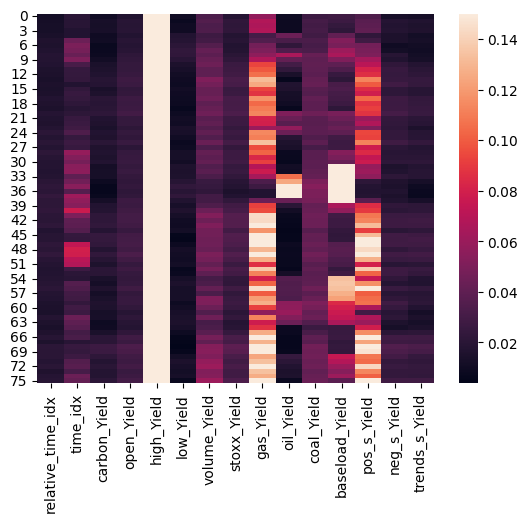

In [244]:
import seaborn as sns
sns.heatmap(heatmap, vmax=0.15)

In [250]:
heatmap2 = pd.DataFrame(np.array(interpretation['attention'].cpu()), 
                       columns=['5','4','3','2','1'])
heatmap2.to_csv('interpretation_timeindex_heatmap.csv',index=0)
heatmap2

,5,4,3,2,1
0,0.171293,0.307913,0.155763,0.216476,0.148555
1,0.273391,0.150306,0.208781,0.142920,0.224601
2,0.150461,0.234837,0.149446,0.234704,0.230553
3,0.241408,0.149059,0.210737,0.232952,0.165843
4,0.166801,0.239692,0.271750,0.196993,0.124764
...,...,...,...,...,...
71,0.206940,0.204557,0.257328,0.119540,0.211634
72,0.233833,0.233257,0.105980,0.205358,0.221573
73,0.219121,0.105394,0.216560,0.241097,0.217828
74,0.110790,0.232418,0.247320,0.210657,0.198816


<AxesSubplot: >

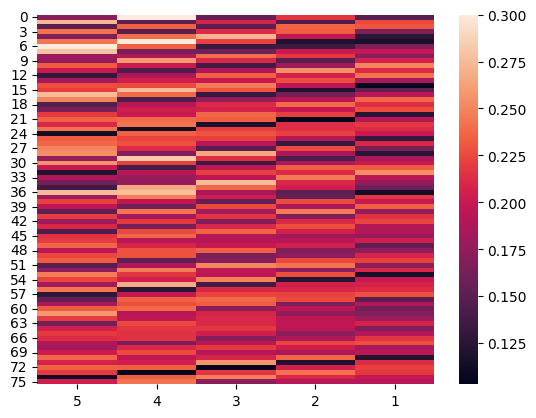

In [233]:
import seaborn as sns
sns.heatmap(heatmap2, vmax=0.3)